# Constrast Cancer Classification

In [1]:
import numpy as np # matrix tools
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots
import pandas as pd
from glob import glob
import re
from skimage.io import imread
import os
import keras

Using TensorFlow backend.


In [2]:
%matplotlib inline

## Exploratory data analysis

In [3]:
overview = pd.read_csv('overview.csv')
overview.head()

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [4]:
len(overview)

100

In [5]:
overview['Contrast'] = overview['Contrast'].map(lambda x: 1 if x else 0)

C:\Users\HP\.julia\conda\3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


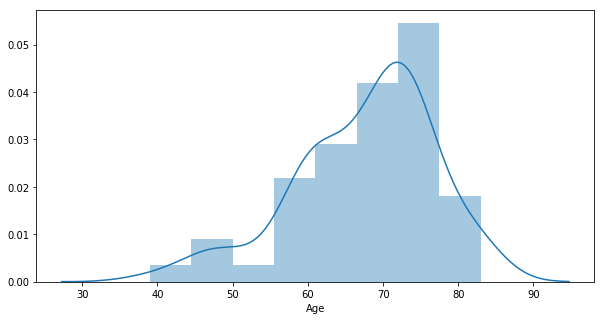

In [6]:
plt.figure(figsize=(10,5))
sns.distplot(overview['Age'])

C:\Users\HP\.julia\conda\3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


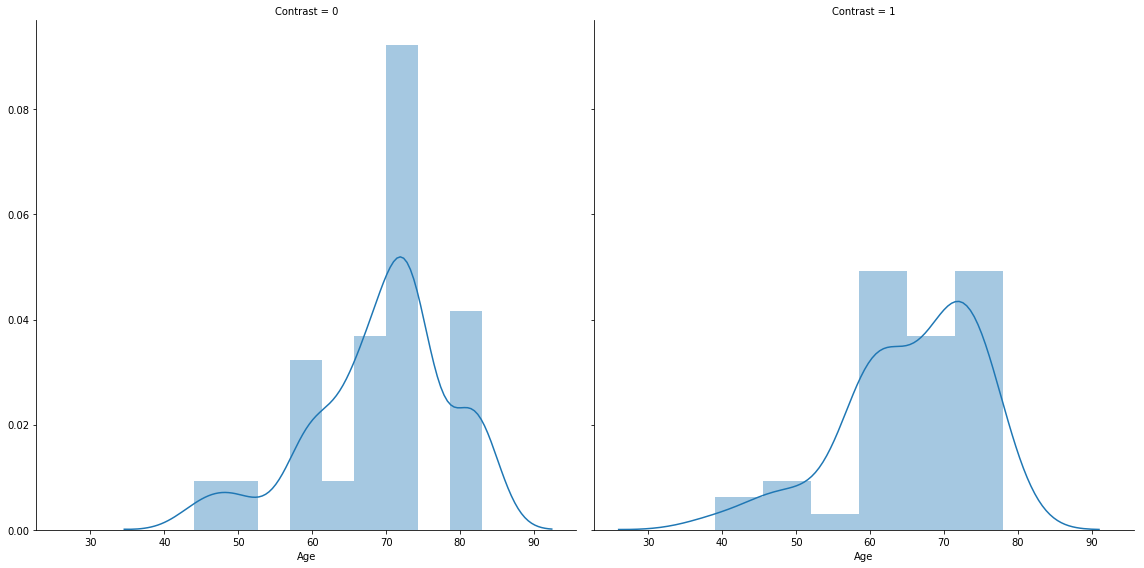

In [7]:
g = sns.FacetGrid(overview, col="Contrast", size=8)
g = g.map(sns.distplot, "Age")

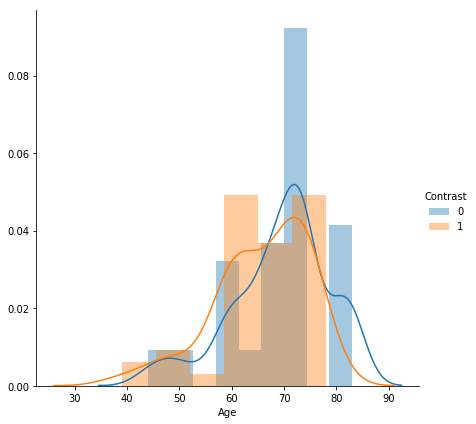

In [8]:
g = sns.FacetGrid(overview, hue="Contrast",size=6, legend_out=True)
g = g.map(sns.distplot, "Age").add_legend()

## Read Image Files 

In [9]:
BASE_IMAGE_PATH = os.path.join("tiff_images")
all_images_list = glob(os.path.join(BASE_IMAGE_PATH,"*.tif"))
all_images_list[:5]

['tiff_images\\ID_0000_AGE_0060_CONTRAST_1_CT.tif',
 'tiff_images\\ID_0001_AGE_0069_CONTRAST_1_CT.tif',
 'tiff_images\\ID_0002_AGE_0074_CONTRAST_1_CT.tif',
 'tiff_images\\ID_0003_AGE_0075_CONTRAST_1_CT.tif',
 'tiff_images\\ID_0004_AGE_0056_CONTRAST_1_CT.tif']

 - np.expand_dims -> Expand the shape of an array.
  - Insert a new axis, corresponding to a given position in the array shape.

In [10]:
imread(all_images_list[0]).shape

(512, 512)

In [11]:
np.array(np.arange(81)).reshape(9,9)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]])

In [12]:
np.array(np.arange(81)).reshape(9,9)[::3,::3]

array([[ 0,  3,  6],
       [27, 30, 33],
       [54, 57, 60]])

In [13]:
np.expand_dims(imread(all_images_list[0])[::4,::4],0).shape

(1, 128, 128)

In [14]:
jimread = lambda x: np.expand_dims(imread(x)[::2,::2],0)

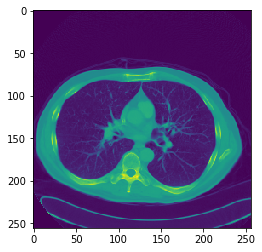

In [15]:
test_image = jimread(all_images_list[0])
plt.imshow(test_image[0])

In [16]:
check_contrast = re.compile(r'ID_([\d]+)_AGE_[\d]+_CONTRAST_([\d]+)_CT.tif')
label = []
id_list = []
for image in all_images_list:
    id_list.append(check_contrast.findall(image)[0][0])
    label.append(check_contrast.findall(image)[0][1])

In [17]:
label_list = pd.DataFrame(label,id_list)

In [18]:
label_list.head()

,0
0000,1
0001,1
0002,1
0003,1
0004,1


In [19]:
images = np.stack([jimread(i) for i in all_images_list],0)

In [20]:
len(images)

100

## Split Data to Train, Test

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images, label_list, test_size=0.1, random_state=0)

## Reshape image Data 

In [23]:
n_train, depth, width, height = X_train.shape
n_test,_,_,_ = X_test.shape

In [24]:
n_train,depth, width, height

(90, 1, 256, 256)

In [25]:
input_shape = (width,height,depth)

In [26]:
input_shape

(256, 256, 1)

In [27]:
input_train = X_train.reshape((n_train, width,height,depth))
input_train.shape
input_train.astype('float32')
input_train = input_train / np.max(input_train)
input_train.max()

1.0

In [28]:
input_test = X_test.reshape(n_test, *input_shape)
input_test.astype('float32')
input_test = input_test / np.max(input_test)

In [29]:
output_train = keras.utils.to_categorical(y_train, 2)
output_test = keras.utils.to_categorical(y_test, 2)
output_train[5]

array([0., 1.], dtype=float32)

In [30]:
input_train.shape

(90, 256, 256, 1)

## Network

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D

In [50]:
batch_size = 20
epochs = 7

## Model 2

In [51]:
model2 = Sequential()
model2.add(Conv2D(50, (5, 5), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(3, 3))) # 3x3 Maxpooling 
model2.add(Conv2D(30, (4, 4), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2))) # 2x2 Maxpooling 
model2.add(Flatten()) 
model2.add(Dense(2, activation='softmax'))

In [52]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 252, 252, 50)      1300      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 84, 84, 50)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 81, 81, 30)        24030     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 40, 30)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 96002     
Total params: 121,332
Trainable params: 121,332
Non-trainable params: 0
_________________________________________________________________


In [53]:
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [54]:
history = model2.fit(input_train, output_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(input_test, output_test))

Train on 90 samples, validate on 10 samples
Epoch 1/7
90/90 [==============================] - 14s 154ms/step - loss: 0.7402 - acc: 0.5444 - val_loss: 0.6082 - val_acc: 0.7000
Epoch 2/7
90/90 [==============================] - 14s 154ms/step - loss: 0.6769 - acc: 0.5333 - val_loss: 0.6591 - val_acc: 0.7000
Epoch 3/7
90/90 [==============================] - 13s 149ms/step - loss: 0.6453 - acc: 0.5556 - val_loss: 0.6564 - val_acc: 0.7000
Epoch 4/7
90/90 [==============================] - 13s 149ms/step - loss: 0.5127 - acc: 0.9000 - val_loss: 0.5037 - val_acc: 0.8000
Epoch 5/7
90/90 [==============================] - 13s 148ms/step - loss: 0.4210 - acc: 0.9000 - val_loss: 0.5058 - val_acc: 0.8000
Epoch 6/7
90/90 [==============================] - 13s 148ms/step - loss: 0.2744 - acc: 0.9444 - val_loss: 0.4878 - val_acc: 0.8000
Epoch 7/7
90/90 [==============================] - 13s 148ms/step - loss: 0.1704 - acc: 0.9667 - val_loss: 0.2666 - val_acc: 0.8000


In [55]:
score = model2.evaluate(input_test, output_test, verbose=0)
score

[0.26657742261886597, 0.800000011920929]